# Preparation Agent
This notebook is dedicated to the data extraction and basic preparation done in the notebook 'Preparation Agent'. We start by installing dependencies that we need.
As previously, Helper functions will be used. Available on GitHub.

In [1]:
import pandas as pd
import numpy as np
import os
dir = 'D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main'
os.chdir(dir)

from helper_functions import Helper
from agents import Preparation_Agent
import pandas as pd

helper = Helper()

dbfile  = "D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main/home-assistant_v2.db"

C:\Users\chris\anaconda3\envs\recomm\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The helper functions will be used as in the previous works. Available at GitHub

### SQL Data Pulling

I removed the code for other databases as we will stick to the one called 'states'. In my own database I see states and attributes in different databases. 
<font color='red'>Check with Alona how she managed to put them together. And which version do we use? Did she send us updated data?
</font> 
For now databases will be in the same form as in the first Alona's file.

Note, initialization function contains also the function for SQL Pulling. <font color='red'> If you have any optimization ideas, please bring it in! </font>

In [2]:
class Preparation_Agent:
    import pandas as pd
    helper = Helper()
    def __init__(self, dbfile, shiftable_devices, activity_devices = None, training_days = 30):
        self.input = helper.export_sql(file = dbfile, number_days = training_days)
        self.shiftable_devices = shiftable_devices
        self.activity_devices = activity_devices + shiftable_devices
        self.training_days = training_days

In [3]:
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]
activity_devices = ["light.olaf_der_gesundigte", "light.blub", "light.extended_color_light_1", "switch.shellyplug_s_80646f824e22", 
                    "light.bogenleuchte", "light.hue_color_candle_1", "light.hue_color_candle_2"]
training_days = 360

In [4]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices, training_days)
prep.input

,state_id,entity_id,state,attributes,event_id,last_changed,last_updated,old_state_id,attributes_id,context_id,context_user_id,context_parent_id,origin_idx,last_updated_ts,last_changed_ts,hash,shared_attrs
0,1,update.home_assistant_supervisor_update,off,None,None,None,None,NaN,1,01GN5842Q23HBMB7EZ6KY9A13R,None,None,0,2022-12-25 18:18:34.594923008,NaN,2939789592,"{""auto_update"":true,""installed_version"":""2022...."
1,2,update.home_assistant_core_update,off,None,None,None,None,NaN,2,01GN5842Q3P07WA0KC0S4WMRZ4,None,None,0,2022-12-25 18:18:34.595604992,NaN,2651871198,"{""auto_update"":false,""installed_version"":""2022..."
2,3,update.home_assistant_operating_system_update,off,None,None,None,None,NaN,3,01GN5842Q4738MTF23J7WJFNA8,None,None,0,2022-12-25 18:18:34.596292864,NaN,2287136131,"{""auto_update"":false,""installed_version"":""9.4""..."
3,4,sun.sun,below_horizon,None,None,None,None,NaN,4,01GN58432SXZ8BV6NEGP0NDMQF,None,None,0,2022-12-25 18:18:34.969049856,NaN,1454287034,"{""friendly_name"":""Sun""}"
4,5,zone.home,0,None,None,None,None,NaN,5,01GN58432VZ0634BF3S40SSSPA,None,None,0,2022-12-25 18:18:34.971450112,NaN,1858961947,"{""latitude"":0,""longitude"":0,""radius"":100,""pass..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991536,991537,light.olaf_der_gesundigte,unavailable,None,None,None,None,991522.0,26782,01GVWWERYTT8RJ1X6EQ9FK47X9,None,None,0,2023-03-19 12:10:39.450475008,NaN,3016127375,"{""icon"":""mdi:desk-lamp"",""friendly_name"":""Olaf ..."
991537,991538,sensor.shellyplug_s_80646f83efe1_power,0.0,None,None,None,None,991535.0,6616,01GVWWF1388HDD7VXTAJ6MKW3W,None,None,0,2023-03-19 12:10:47.784705024,NaN,3126907861,"{""state_class"":""measurement"",""unit_of_measurem..."
991538,991539,sensor.shellyplug_s_4022d88961b4_power,0.4,None,None,None,None,991534.0,60,01GVWWF305N6KR67SCFN8JKAFQ,None,None,0,2023-03-19 12:10:49.733405952,NaN,636637236,"{""state_class"":""measurement"",""unit_of_measurem..."
991539,991540,light.extended_color_light_1,off,None,None,None,None,991533.0,26882,01GVWWFC9KX1P2PA84C7ECVAXF,None,None,0,2023-03-19 12:10:59.251194112,NaN,123883301,"{""mode"":""normal"",""dynamics"":""none"",""icon"":""mdi..."


In [5]:
prep.input.columns

Index(['state_id', 'entity_id', 'state', 'attributes', 'event_id',
       'last_changed', 'last_updated', 'old_state_id', 'attributes_id',
       'context_id', 'context_user_id', 'context_parent_id', 'origin_idx',
       'last_updated_ts', 'last_changed_ts', 'hash', 'shared_attrs'],
      dtype='object')

### Data Unpacking
We received data frame that has dictionaries in column value. In this section, we bring the data frame to the wide format, additionally unpacking the column. After that I specify that I need values in kWh and choose nodes. <font color='red'>Note: user should specify the nodes. How does he do it? Is kWh okay?
</font>

Here I am dropping values but it is not sustainable solution.

In [6]:
#adapted for HA
def unpacking_attributes(self, df):
    output = df.copy()
    output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('true','True'))
    output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('false','False'))
    output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('null','None'))

    output['shared_attrs']=output['shared_attrs'].apply(lambda dat: dict(eval(dat)))
    df2 = pd.json_normalize(output['shared_attrs'])
    result = pd.DataFrame( pd.concat([output,df2], axis = 1).drop('shared_attrs', axis = 1))
    result = result.dropna(axis = 1, thresh=int(0.95*(len(result.columns))))
    return result

setattr(Preparation_Agent, 'unpacking_attributes', unpacking_attributes)
del unpacking_attributes

In [7]:
data_unpacked  = prep.unpacking_attributes(prep.input)

In [8]:
data_unpacked

,state_id,entity_id,state,old_state_id,attributes_id,context_id,context_user_id,context_parent_id,origin_idx,last_updated_ts,...,backups_in_home_assistant,size_in_google_drive,size_in_home_assistant,backups,free_space_in_google_drive,motion_valid,light_level,light_level_valid,temperature_valid,number
0,1,update.home_assistant_supervisor_update,off,NaN,1,01GN5842Q23HBMB7EZ6KY9A13R,None,None,0,2022-12-25 18:18:34.594923008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,update.home_assistant_core_update,off,NaN,2,01GN5842Q3P07WA0KC0S4WMRZ4,None,None,0,2022-12-25 18:18:34.595604992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,update.home_assistant_operating_system_update,off,NaN,3,01GN5842Q4738MTF23J7WJFNA8,None,None,0,2022-12-25 18:18:34.596292864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,sun.sun,below_horizon,NaN,4,01GN58432SXZ8BV6NEGP0NDMQF,None,None,0,2022-12-25 18:18:34.969049856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,zone.home,0,NaN,5,01GN58432VZ0634BF3S40SSSPA,None,None,0,2022-12-25 18:18:34.971450112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991536,991537,light.olaf_der_gesundigte,unavailable,991522.0,26782,01GVWWERYTT8RJ1X6EQ9FK47X9,None,None,0,2023-03-19 12:10:39.450475008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991537,991538,sensor.shellyplug_s_80646f83efe1_power,0.0,991535.0,6616,01GVWWF1388HDD7VXTAJ6MKW3W,None,None,0,2023-03-19 12:10:47.784705024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991538,991539,sensor.shellyplug_s_4022d88961b4_power,0.4,991534.0,60,01GVWWF305N6KR67SCFN8JKAFQ,None,None,0,2023-03-19 12:10:49.733405952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991539,991540,light.extended_color_light_1,off,991533.0,26882,01GVWWFC9KX1P2PA84C7ECVAXF,None,None,0,2023-03-19 12:10:59.251194112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_unpacked.columns

Index(['state_id', 'entity_id', 'state', 'old_state_id', 'attributes_id',
       'context_id', 'context_user_id', 'context_parent_id', 'origin_idx',
       'last_updated_ts', 'last_changed_ts', 'hash', 'state_class',
       'unit_of_measurement', 'device_class', 'friendly_name', 'icon', 'type',
       'temperature', 'temperature_unit', 'humidity', 'pressure',
       'pressure_unit', 'wind_bearing', 'wind_speed', 'wind_speed_unit',
       'visibility', 'visibility_unit', 'precipitation_unit', 'country_code',
       'level', 'min_color_temp_kelvin', 'max_color_temp_kelvin', 'mode',
       'dynamics', 'current', 'voltage', 'color_mode', 'brightness',
       'hs_color', 'rgb_color', 'xy_color', 'effect', 'is_hue_group',
       'hue_scenes', 'hue_type', 'lights', 'color_temp_kelvin', 'color_temp',
       'auto_update', 'installed_version', 'latest_version', 'release_url',
       'title', 'editable', 'battery_state', 'group_name', 'group_type',
       'name', 'speed', 'is_dynamic', 'last_bac

Attributes ID is not unique for one entity, therefore we use entity_id to identify the different sensors

In [ ]:
data_unpacked.loc[data_unpacked['entity_id'] == "sensor.shellyplug_s_4022d88984b8_power"].attributes_id.unique()

In [ ]:
data_unpacked.unit_of_measurement.unique()

In [ ]:
W_data = data_unpacked[data_unpacked.unit_of_measurement=='W']
W_data

In [ ]:
W_data.columns

In [ ]:
W_data = W_data.iloc[:,0:13]
W_data

In [ ]:
W_data.entity_id.unique()

In [11]:
trial = data_unpacked.copy()
trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
w_data = trial[trial.entity_id.isin(prep.shiftable_devices)]
w_data = w_data[trial.unit_of_measurement.isin(['W'])]
#we can add entity_id, or disregard
w_data_long = w_data[['entity_id','last_updated_ts','state']]
w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
w_data_wide = w_data_wide.fillna(0).reset_index()

w_data_wide

Boolean Series key will be reindexed to match DataFrame index.


entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-02-18 17:51:12.175996160,0.40,0.0
1,2023-02-18 17:51:27.174832128,0.50,0.0
2,2023-02-18 17:51:42.194142208,0.40,0.0
3,2023-02-18 17:52:12.194013184,0.30,0.0
4,2023-02-18 17:52:57.195159808,0.50,0.0
...,...,...,...
66220,2023-03-19 12:09:49.726473216,0.44,0.0
66221,2023-03-19 12:10:04.725435904,0.41,0.0
66222,2023-03-19 12:10:19.725108992,0.40,0.0
66223,2023-03-19 12:10:34.734262016,0.38,0.0


In [14]:
trial = data_unpacked.copy()
s_data = trial[trial.state == 'on']
s_data.state.loc[s_data.state == 'on'] = 1
s_data = s_data[trial.entity_id.isin(prep.activity_devices)]
#we can add entity_id, or disregard
s_data_long = s_data[['entity_id','last_updated_ts','state']]
s_data_wide = pd.pivot(s_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')

s_data_wide = s_data_wide.fillna(0).reset_index()
s_data_wide




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


entity_id,last_updated_ts,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
0,2023-02-20 15:43:19.104815872,0,0,1,0,0,0,0
1,2023-02-20 15:43:19.106766848,0,0,0,0,0,1,0
2,2023-02-20 15:43:19.110029056,1,0,0,0,0,0,0
3,2023-02-20 15:56:15.188016896,1,0,0,0,0,0,0
4,2023-02-20 15:56:15.190979840,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2551,2023-03-18 23:17:23.724399104,0,0,0,1,0,0,0
2552,2023-03-18 23:17:23.730386944,0,0,0,0,1,0,0
2553,2023-03-18 23:17:24.732954112,0,1,0,0,0,0,0
2554,2023-03-18 23:17:24.737384192,0,0,0,1,0,0,0


In [15]:
pd.merge(w_data_wide, s_data_wide, how='outer')

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
0,2023-02-18 17:51:12.175996160,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-18 17:51:27.174832128,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-18 17:51:42.194142208,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-18 17:52:12.194013184,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-18 17:52:57.195159808,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
68776,2023-03-18 23:17:23.724399104,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68777,2023-03-18 23:17:23.730386944,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68778,2023-03-18 23:17:24.732954112,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68779,2023-03-18 23:17:24.737384192,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Accessing only nodes in W
Not optimally written code! However, this function only takes entities that have consumption in kWh and nodes defined by the user. <font color = 'red'> Next question is how to merge it with the home assistant so user can define which node to use? Also tried to get rid of NaN column, why it didn't work out? </font>

In [31]:
#updated
def create_friendly_names(self, df):
    from datetime import datetime
    trial = df.copy()
    trial.attributes_id = trial.attributes_id.dropna()
    trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
    w_data = trial[trial.unit_of_measurement.isin(['W'])]
    w_data = w_data[w_data.entity_id.isin(self.shiftable_devices)]
    last_30_days = (datetime.now() - pd.Timedelta(days=30)).strftime("%Y-%m-%d")
    w_data = w_data[(w_data['last_updated_ts'] > last_30_days)]
    friendly_names = w_data[['entity_id','friendly_name']]
    friendly_name_map = friendly_names.drop_duplicates()
    return(friendly_name_map)

setattr(Preparation_Agent, 'create_friendly_names', create_friendly_names)
del create_friendly_names

In [32]:
friendly_names = prep.create_friendly_names(data_unpacked)
friendly_names

,entity_id,friendly_name
609947,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power
618740,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power


In [19]:
#updated
def access_activity_devices(self, df, activity_devices):
    # data for watt devices
    trial = data_unpacked.copy()
    trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
    w_data = trial[trial.entity_id.isin(prep.activity_devices)]
    w_data = w_data[trial.unit_of_measurement.isin(['W'])]
    #we can add entity_id, or disregard
    w_data_long = w_data[['entity_id','last_updated_ts','state']]
    w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
    w_data_wide = w_data_wide.fillna(0).reset_index()
    # data for state devices
    trial = data_unpacked.copy()
    s_data = trial[trial.state == 'on']
    s_data.state.loc[s_data.state == 'on'] = 1
    s_data = s_data[trial.entity_id.isin(prep.activity_devices)]
    #we can add entity_id, or disregard
    s_data_long = s_data[['entity_id','last_updated_ts','state']]
    s_data_wide = pd.pivot(s_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
    s_data_wide = s_data_wide.fillna(0).reset_index()
    
    result = pd.merge(w_data_wide, s_data_wide, how='outer')
    return(result)

setattr(Preparation_Agent, 'access_activity_devices', access_activity_devices)
del access_activity_devices

In [23]:
data_act = prep.access_activity_devices(data_unpacked, prep.activity_devices)
data_act

Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
0,2023-02-18 17:51:12.175996160,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-18 17:51:27.174832128,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-18 17:51:42.194142208,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-18 17:52:12.194013184,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-18 17:52:57.195159808,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
68776,2023-03-18 23:17:23.724399104,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68777,2023-03-18 23:17:23.730386944,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68778,2023-03-18 23:17:24.732954112,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68779,2023-03-18 23:17:24.737384192,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [130]:
def access_shiftable_devices(self, df, attrs= 'all'):
    import pandas as pd
    trial = df.copy()
    trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
    if attrs == 'all':
        w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.entity_id.isin(self.shiftable_devices)]
        w_data_long = w_data[['entity_id','last_updated_ts','state']]
        w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
    if attrs != 'all':
        w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.entity_id.isin(self.shiftable_devices)]
        w_data_long = w_data[['entity_id','last_updated_ts','state']]
        w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
    result = w_data_wide.fillna(0).reset_index()
    return(result)

setattr(Preparation_Agent, 'access_shiftable_devices', access_shiftable_devices)
del access_shiftable_devices

In [131]:
data_w = prep.access_shiftable_devices(data_unpacked)
data_w

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-02-18 17:51:12.175996160,0.40,0.0
1,2023-02-18 17:51:27.174832128,0.50,0.0
2,2023-02-18 17:51:42.194142208,0.40,0.0
3,2023-02-18 17:52:12.194013184,0.30,0.0
4,2023-02-18 17:52:57.195159808,0.50,0.0
...,...,...,...
66220,2023-03-19 12:09:49.726473216,0.44,0.0
66221,2023-03-19 12:10:04.725435904,0.41,0.0
66222,2023-03-19 12:10:19.725108992,0.40,0.0
66223,2023-03-19 12:10:34.734262016,0.38,0.0


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_w[['last_updated_ts','sensor.shellyplug_s_4022d88984b8_power']])

### Standard Data Preprocessing - Outlier Truncation
Here comes <font color='red'> the first issue </font>, the consumption which was reported is really low. When we apply outlier truncation, all values that are not zero becoming zeros. Therefore, should we skip outlier truncation step?
I am taking kWh - kilowatt hour. <font color='red'> Do you think I should take W better  </font>? Below one can see that only node 3 and 46 are active and activity is super low. I will create outlier truncation but I do not think that it should be applied.

In [ ]:
# Histogram
data_w.hist(bins=10, figsize=(8,8));

In [ ]:
data_w.isna().any()

Skewed data, no outliers <font color = 'red'> (as I personally believe) </font>. Data has no missing values. However, as I am not sure whether this will be the case with any data I will keep truncation functions.

In [30]:
data_w.describe()

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
count,66225.000000,66225.000000
mean,69.624602,81.759739
std,344.108510,326.973662
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.300000,0.000000
75%,0.400000,48.000000
max,1884.600000,2272.300000


In [31]:
data_w

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-02-18 17:51:12.175996160,0.40,0.0
1,2023-02-18 17:51:27.174832128,0.50,0.0
2,2023-02-18 17:51:42.194142208,0.40,0.0
3,2023-02-18 17:52:12.194013184,0.30,0.0
4,2023-02-18 17:52:57.195159808,0.50,0.0
...,...,...,...
66220,2023-03-19 12:09:49.726473216,0.44,0.0
66221,2023-03-19 12:10:04.725435904,0.41,0.0
66222,2023-03-19 12:10:19.725108992,0.40,0.0
66223,2023-03-19 12:10:34.734262016,0.38,0.0


In [32]:
def outlier_truncation(self, series, factor=1.5, verbose=0):
    from tqdm import tqdm
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    
    lower_bound = q1 - factor*iqr
    upper_bound = q3 + factor*iqr
    
    output = []
    counter = 0
    for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
        if item > upper_bound:
            output.append(int(upper_bound))
            counter += 1
        elif item < lower_bound:
            output.append(int(lower_bound))
            counter += 1
        else:
            output.append(item)
    print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
    return output

# add the function to the class and delete global function
setattr(Preparation_Agent, 'outlier_truncation', outlier_truncation)
del outlier_truncation

In [ ]:
new_df = pd.DataFrame()
new_df['573 truncated'] = prep.outlier_truncation(data_w["sensor.shellyplug_s_4022d88984b8_power"], verbose = 1)
new_df.describe()

In [ ]:
# truncating multiple features
def truncate(self, df, features='all', factor=1.5, verbose=0):
    import time
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

    for feature in features:
        time.sleep(0.2) if verbose != 0 else None
        row_nn = df[feature] != 0                                                                  # truncate only the values for which the device uses energy
        output.loc[row_nn, feature] = self.outlier_truncation(df.loc[row_nn, feature], factor=factor, verbose=verbose) # Truncatation factor = 1.5 * IQR
        print('\n') if verbose != 0 else None
    return output

# add to class
setattr(Preparation_Agent, 'truncate', truncate)
del truncate

In [ ]:
household_t = prep.truncate(data_w, verbose = 1)
household_t.describe().round(2)

### MinMax Scaling

In [ ]:
def scale(self, df, features='all', kind='MinMax', verbose=0):
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features
    
    if kind == 'MinMax':
        from sklearn.preprocessing import MinMaxScaler
        
        scaler = MinMaxScaler()
        output[features] = scaler.fit_transform(df[features])
        print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
    else:
        raise InputError('Chosen scaling method is not available.')
    return output 

# add to the class
setattr(Preparation_Agent, 'scale', scale)
del scale

In [ ]:
household_s = prep.scale(household_t, verbose = 0)

In [ ]:
household_s

### Feature Creation

**Resampling by hour**
First, I will create the function that aggregates the dataframe for the period X, it can be 60 minutes, it can be one day. It is resampled this way, that we receive sum of the variables per hour/day and not the average as in initial preparation agent. <font color = 'red'> If you consider that we should take mean, please let me know. </font>


In [29]:
def get_timespan(self, df, start, timedelta_params):
    df.last_updated_ts = pd.to_datetime(df.last_updated_ts)
    df = df.set_index('last_updated_ts')
    start = pd.to_datetime(start) if type(start) != type(pd.to_datetime('1970-01-01')) else start 
    end = start + pd.Timedelta(**timedelta_params)
    return df[start:end].reset_index()

# add to the helper class
setattr(Helper, 'get_timespan', get_timespan)
del get_timespan

In [34]:
# Extracting data for one day
helper = Helper()
from datetime import datetime

timedelta_params = {'days': 1, 'seconds': -1}   # returns data for just one day
day = helper.get_timespan(data_w, "2023-03-15", timedelta_params)
day

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-03-15 08:57:21.330704896,0.57,0.0
1,2023-03-15 08:57:25.319155968,23.80,0.0
2,2023-03-15 08:57:26.319963904,18.84,0.0
3,2023-03-15 08:57:35.321073920,17.74,0.0
4,2023-03-15 08:57:50.334508800,17.85,0.0
...,...,...,...
3481,2023-03-15 23:58:31.474941952,0.34,0.0
3482,2023-03-15 23:58:46.464699136,0.42,0.0
3483,2023-03-15 23:59:16.464109824,0.36,0.0
3484,2023-03-15 23:59:31.482834944,0.39,0.0


In [35]:
#aggregating per hour
data = day.resample('60T', on = 'last_updated_ts').mean()
data.describe().round(3)


entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
count,16.000,16.0
mean,67.912,0.0
std,223.146,0.0
min,0.359,0.0
25%,0.364,0.0
50%,0.372,0.0
75%,0.381,0.0
max,887.862,0.0


In [36]:
data

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-03-15 08:00:00,14.500000,0.0
2023-03-15 09:00:00,887.862474,0.0
2023-03-15 10:00:00,179.423806,0.0
2023-03-15 11:00:00,0.369123,0.0
2023-03-15 12:00:00,0.363244,0.0
2023-03-15 13:00:00,0.358578,0.0
2023-03-15 14:00:00,0.362152,0.0
2023-03-15 15:00:00,0.359342,0.0
2023-03-15 16:00:00,0.368274,0.0


<font color = 'red'> Mean gives back NaN if there are only 0! So we have to replace all nan values with 0. Otherwise later on the load agent does not find right load patterns.</font>.

In [37]:
output = data_w.copy()
output.last_updated_ts

0       2023-02-18 17:51:12.175996160
1       2023-02-18 17:51:27.174832128
2       2023-02-18 17:51:42.194142208
3       2023-02-18 17:52:12.194013184
4       2023-02-18 17:52:57.195159808
                     ...             
66220   2023-03-19 12:09:49.726473216
66221   2023-03-19 12:10:04.725435904
66222   2023-03-19 12:10:19.725108992
66223   2023-03-19 12:10:34.734262016
66224   2023-03-19 12:10:49.733405952
Name: last_updated_ts, Length: 66225, dtype: datetime64[ns]

In [38]:
output['last_updated_ts'] = pd.to_datetime(output['last_updated_ts'])
output

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-02-18 17:51:12.175996160,0.40,0.0
1,2023-02-18 17:51:27.174832128,0.50,0.0
2,2023-02-18 17:51:42.194142208,0.40,0.0
3,2023-02-18 17:52:12.194013184,0.30,0.0
4,2023-02-18 17:52:57.195159808,0.50,0.0
...,...,...,...
66220,2023-03-19 12:09:49.726473216,0.44,0.0
66221,2023-03-19 12:10:04.725435904,0.41,0.0
66222,2023-03-19 12:10:19.725108992,0.40,0.0
66223,2023-03-19 12:10:34.734262016,0.38,0.0


In [39]:
output.last_updated_ts

0       2023-02-18 17:51:12.175996160
1       2023-02-18 17:51:27.174832128
2       2023-02-18 17:51:42.194142208
3       2023-02-18 17:52:12.194013184
4       2023-02-18 17:52:57.195159808
                     ...             
66220   2023-03-19 12:09:49.726473216
66221   2023-03-19 12:10:04.725435904
66222   2023-03-19 12:10:19.725108992
66223   2023-03-19 12:10:34.734262016
66224   2023-03-19 12:10:49.733405952
Name: last_updated_ts, Length: 66225, dtype: datetime64[ns]

In [40]:
output = output.resample('60T', on="last_updated_ts").mean()
output

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-02-18 17:00:00,0.361111,0.0
2023-02-18 18:00:00,0.354545,0.0
2023-02-18 19:00:00,0.372414,0.0
2023-02-18 20:00:00,0.360305,0.0
2023-02-18 21:00:00,0.354135,0.0
...,...,...
2023-03-19 08:00:00,NaN,NaN
2023-03-19 09:00:00,1250.769756,0.0
2023-03-19 10:00:00,610.157577,0.0


In [41]:
output = output.replace(np.nan, 0)
output

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-02-18 17:00:00,0.361111,0.0
2023-02-18 18:00:00,0.354545,0.0
2023-02-18 19:00:00,0.372414,0.0
2023-02-18 20:00:00,0.360305,0.0
2023-02-18 21:00:00,0.354135,0.0
...,...,...
2023-03-19 08:00:00,0.000000,0.0
2023-03-19 09:00:00,1250.769756,0.0
2023-03-19 10:00:00,610.157577,0.0


<font color = 'red'> In Zharova's approach there is function aggregate, I changed it to resampling. Note, she takes **mean**, I take sum as hourly total consumption </font>.

In [42]:
#def aggregate(self, df, resample_param):
#    return df.resample(resample_param).mean().copy()

In [43]:
# add to helper and not to preparation agent
def aggregate(self, df, period = '60T'):
    output = df.copy()
    output['last_updated_ts'] = pd.to_datetime(output['last_updated_ts'])
    output = output.resample(period, on="last_updated_ts").mean()
    output = output.replace(np.nan, 0)
    return output

setattr(Preparation_Agent, 'aggregate', aggregate)
del aggregate

In [44]:
data_w

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-02-18 17:51:12.175996160,0.40,0.0
1,2023-02-18 17:51:27.174832128,0.50,0.0
2,2023-02-18 17:51:42.194142208,0.40,0.0
3,2023-02-18 17:52:12.194013184,0.30,0.0
4,2023-02-18 17:52:57.195159808,0.50,0.0
...,...,...,...
66220,2023-03-19 12:09:49.726473216,0.44,0.0
66221,2023-03-19 12:10:04.725435904,0.41,0.0
66222,2023-03-19 12:10:19.725108992,0.40,0.0
66223,2023-03-19 12:10:34.734262016,0.38,0.0


In [45]:
data = prep.aggregate(data_w)
data

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-02-18 17:00:00,0.361111,0.0
2023-02-18 18:00:00,0.354545,0.0
2023-02-18 19:00:00,0.372414,0.0
2023-02-18 20:00:00,0.360305,0.0
2023-02-18 21:00:00,0.354135,0.0
...,...,...
2023-03-19 08:00:00,0.000000,0.0
2023-03-19 09:00:00,1250.769756,0.0
2023-03-19 10:00:00,610.157577,0.0


In [46]:
def plot_consumption(self, df, features='all', figsize='default', threshold=None, title='Consumption'):
    import matplotlib.pyplot as plt

    df = df.copy()
    features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features

    fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
    if threshold != None:
        df['threshold'] = [threshold]*df.shape[0]
        ax.plot(df['threshold'], color = 'tab:red')
    for feature in features:
        ax.plot(df[feature])
    ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
    ax.set_title(title);

# add to the class
setattr(Preparation_Agent, 'plot_consumption', plot_consumption)
del plot_consumption


<font color='red'> **How do we define the threshold in our case?** </font> I randomly took threshold in this case.


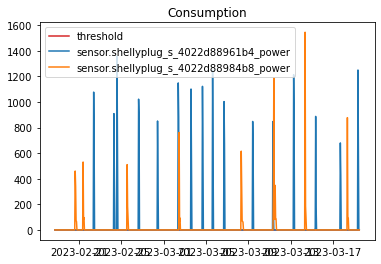

In [47]:
prep.plot_consumption(data, threshold = 1)

**Device Usage Feature**

In [48]:
def get_device_usage(self, df, device, threshold):
    return (df.loc[:, device] >= threshold).astype('int')

# add to class
setattr(Preparation_Agent, 'get_device_usage', get_device_usage)
del get_device_usage

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(prep.get_device_usage(data, "sensor.shellyplug_s_4022d88984b8_power", 1))



last_updated_ts
2023-02-18 17:00:00    0
2023-02-18 18:00:00    0
2023-02-18 19:00:00    0
2023-02-18 20:00:00    0
2023-02-18 21:00:00    0
2023-02-18 22:00:00    0
2023-02-18 23:00:00    0
2023-02-19 00:00:00    0
2023-02-19 01:00:00    0
2023-02-19 02:00:00    0
2023-02-19 03:00:00    0
2023-02-19 04:00:00    0
2023-02-19 05:00:00    0
2023-02-19 06:00:00    0
2023-02-19 07:00:00    0
2023-02-19 08:00:00    0
2023-02-19 09:00:00    0
2023-02-19 10:00:00    0
2023-02-19 11:00:00    0
2023-02-19 12:00:00    0
2023-02-19 13:00:00    0
2023-02-19 14:00:00    0
2023-02-19 15:00:00    0
2023-02-19 16:00:00    0
2023-02-19 17:00:00    0
2023-02-19 18:00:00    0
2023-02-19 19:00:00    0
2023-02-19 20:00:00    0
2023-02-19 21:00:00    0
2023-02-19 22:00:00    0
2023-02-19 23:00:00    0
2023-02-20 00:00:00    0
2023-02-20 01:00:00    0
2023-02-20 02:00:00    0
2023-02-20 03:00:00    0
2023-02-20 04:00:00    0
2023-02-20 05:00:00    0
2023-02-20 06:00:00    0
2023-02-20 07:00:00    0
2023-02-2

In [50]:
prep.get_device_usage(data, "sensor.shellyplug_s_4022d88961b4_power", 1)

last_updated_ts
2023-02-18 17:00:00    0
2023-02-18 18:00:00    0
2023-02-18 19:00:00    0
2023-02-18 20:00:00    0
2023-02-18 21:00:00    0
                      ..
2023-03-19 08:00:00    0
2023-03-19 09:00:00    1
2023-03-19 10:00:00    1
2023-03-19 11:00:00    0
2023-03-19 12:00:00    0
Freq: 60T, Name: sensor.shellyplug_s_4022d88961b4_power, Length: 692, dtype: int32

Function that creates binary variable and aggregates in order to show whether variable has been or not used in particular day.

In [62]:
## daily appliance usage
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

for appliance in shiftable_devices:
    data['node'+ str(appliance) + '_usage'] = prep.get_device_usage(data, appliance, 1)
data.filter(regex = 'usage')

data_all = data.copy()

In [63]:
data_all

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage,activity
last_updated_ts,,,,,
2023-02-18 17:00:00,0.361111,0.0,0,0,0
2023-02-18 18:00:00,0.354545,0.0,0,0,0
2023-02-18 19:00:00,0.372414,0.0,0,0,0
2023-02-18 20:00:00,0.360305,0.0,0,0,0
2023-02-18 21:00:00,0.354135,0.0,0,0,0
...,...,...,...,...,...
2023-03-19 08:00:00,0.000000,0.0,0,0,0
2023-03-19 09:00:00,1250.769756,0.0,1,0,1
2023-03-19 10:00:00,610.157577,0.0,1,0,1


Activity feature appear in my notebook a bit ealier than in original one.

In [64]:
def get_activity(self, df, active_appliances, threshold):
    import pandas as pd
    active = pd.DataFrame({appliance: df[appliance] >= threshold for appliance in active_appliances})
    return active.apply(any, axis = 1).astype('int')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_activity', get_activity)
del get_activity

In [65]:
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

data_all['activity'] = prep.get_activity(data_all, shiftable_devices, 1)
data_all

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage,activity
last_updated_ts,,,,,
2023-02-18 17:00:00,0.361111,0.0,0,0,0
2023-02-18 18:00:00,0.354545,0.0,0,0,0
2023-02-18 19:00:00,0.372414,0.0,0,0,0
2023-02-18 20:00:00,0.360305,0.0,0,0,0
2023-02-18 21:00:00,0.354135,0.0,0,0,0
...,...,...,...,...,...
2023-03-19 08:00:00,0.000000,0.0,0,0,0
2023-03-19 09:00:00,1250.769756,0.0,1,0,1
2023-03-19 10:00:00,610.157577,0.0,1,0,1


**Periods since the last device usage**

In [66]:
def get_last_usage(self, series):
    last_usage = []
    for idx in range(len(series)):
        shift = 1
        if pd.isna(series.shift(periods = 1)[idx]):
            shift = None
        else:
            while series.shift(periods = shift)[idx] == 0:
                shift += 1
        last_usage.append(shift)
    return last_usage

def get_last_usages(self, df, features):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        output['periods_since_last_'+str(feature)] = self.get_last_usage(df[feature])
    output.set_index(df.index, inplace=True)
    return output


setattr(Preparation_Agent, 'get_last_usage', get_last_usage)
del get_last_usage

setattr(Preparation_Agent, 'get_last_usages', get_last_usages)
del get_last_usages

In [67]:
usage_cols = data_all.filter(regex = 'usage')

data_all = data_all.join(prep.get_last_usages(data_all, usage_cols))
data_all.iloc[:, -10:]

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage,activity,periods_since_last_nodesensor.shellyplug_s_4022d88961b4_power_usage,periods_since_last_nodesensor.shellyplug_s_4022d88984b8_power_usage
last_updated_ts,,,,,,,
2023-02-18 17:00:00,0.361111,0.0,0,0,0,NaN,NaN
2023-02-18 18:00:00,0.354545,0.0,0,0,0,2.0,2.0
2023-02-18 19:00:00,0.372414,0.0,0,0,0,3.0,3.0
2023-02-18 20:00:00,0.360305,0.0,0,0,0,4.0,4.0
2023-02-18 21:00:00,0.354135,0.0,0,0,0,5.0,5.0
...,...,...,...,...,...,...,...
2023-03-19 08:00:00,0.000000,0.0,0,0,0,38.0,21.0
2023-03-19 09:00:00,1250.769756,0.0,1,0,1,39.0,22.0
2023-03-19 10:00:00,610.157577,0.0,1,0,1,1.0,23.0


**Time Features Based on DatetimeIndex**

In [68]:
def get_time_feature(self, df, features='all'):
    import pandas as pd
    functions = {
        'hour': lambda df: df.index.hour, 
        'day_of_week': lambda df: df.index.dayofweek,
        'day_name': lambda df: df.index.day_name().astype('category'),
        'month': lambda df: df.index.month, 
        'month_name': lambda df: df.index.month_name().astype('category'),
        'weekend': lambda df: [int(x in ['Saturday', 'Sunday']) for x in  list(df.index.day_name())]
    }
    if features == 'all':
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items()})
    else:
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items() if function[0] in features})
    output.set_index(df.index, inplace=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_feature', get_time_feature)
del get_time_feature

In [69]:
day

entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-03-15 08:57:21.330704896,0.57,0.0
1,2023-03-15 08:57:25.319155968,23.80,0.0
2,2023-03-15 08:57:26.319963904,18.84,0.0
3,2023-03-15 08:57:35.321073920,17.74,0.0
4,2023-03-15 08:57:50.334508800,17.85,0.0
...,...,...,...
3481,2023-03-15 23:58:31.474941952,0.34,0.0
3482,2023-03-15 23:58:46.464699136,0.42,0.0
3483,2023-03-15 23:59:16.464109824,0.36,0.0
3484,2023-03-15 23:59:31.482834944,0.39,0.0


In [70]:
day = day.set_index('last_updated_ts')
day = day.loc[:,["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]]
day = day.reset_index()
day['last_updated_ts']=pd.to_datetime(day['last_updated_ts'])
day = day.set_index('last_updated_ts')
day = day.join(prep.get_time_feature(day))

In [71]:
day.head()

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,hour,day_of_week,day_name,month,month_name,weekend
last_updated_ts,,,,,,,,
2023-03-15 08:57:21.330704896,0.57,0.0,8,2,Wednesday,3,March,0
2023-03-15 08:57:25.319155968,23.80,0.0,8,2,Wednesday,3,March,0
2023-03-15 08:57:26.319963904,18.84,0.0,8,2,Wednesday,3,March,0
2023-03-15 08:57:35.321073920,17.74,0.0,8,2,Wednesday,3,March,0
2023-03-15 08:57:50.334508800,17.85,0.0,8,2,Wednesday,3,March,0


**Time Lag Features**

In [84]:
def get_time_lags(self, df, features, lags):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        for lag in lags:
            output[f'{feature}_lag_{lag}'] = df[feature].shift(periods=lag)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_lags', get_time_lags)
del get_time_lags

In [85]:
day['activity'] = prep.get_activity(day, shiftable_devices, 1)

In [86]:
day

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,hour,day_of_week,day_name,month,month_name,weekend,activity
last_updated_ts,,,,,,,,,
2023-03-15 08:57:21.330704896,0.57,0.0,8,2,Wednesday,3,March,0,0
2023-03-15 08:57:25.319155968,23.80,0.0,8,2,Wednesday,3,March,0,1
2023-03-15 08:57:26.319963904,18.84,0.0,8,2,Wednesday,3,March,0,1
2023-03-15 08:57:35.321073920,17.74,0.0,8,2,Wednesday,3,March,0,1
2023-03-15 08:57:50.334508800,17.85,0.0,8,2,Wednesday,3,March,0,1
...,...,...,...,...,...,...,...,...,...
2023-03-15 23:58:31.474941952,0.34,0.0,23,2,Wednesday,3,March,0,0
2023-03-15 23:58:46.464699136,0.42,0.0,23,2,Wednesday,3,March,0,0
2023-03-15 23:59:16.464109824,0.36,0.0,23,2,Wednesday,3,March,0,0


In [87]:
day = day.join(prep.get_time_lags(day, ['hour','activity'], [1, 2, 5]))
day.iloc[:, -6:]

,hour_lag_1,hour_lag_2,hour_lag_5,activity_lag_1,activity_lag_2,activity_lag_5
last_updated_ts,,,,,,
2023-03-15 08:57:21.330704896,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-15 08:57:25.319155968,8.0,NaN,NaN,0.0,NaN,NaN
2023-03-15 08:57:26.319963904,8.0,8.0,NaN,1.0,0.0,NaN
2023-03-15 08:57:35.321073920,8.0,8.0,NaN,1.0,1.0,NaN
2023-03-15 08:57:50.334508800,8.0,8.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...
2023-03-15 23:58:31.474941952,23.0,23.0,23.0,0.0,0.0,0.0
2023-03-15 23:58:46.464699136,23.0,23.0,23.0,0.0,0.0,0.0
2023-03-15 23:59:16.464109824,23.0,23.0,23.0,0.0,0.0,0.0


### Defining optimal threshold


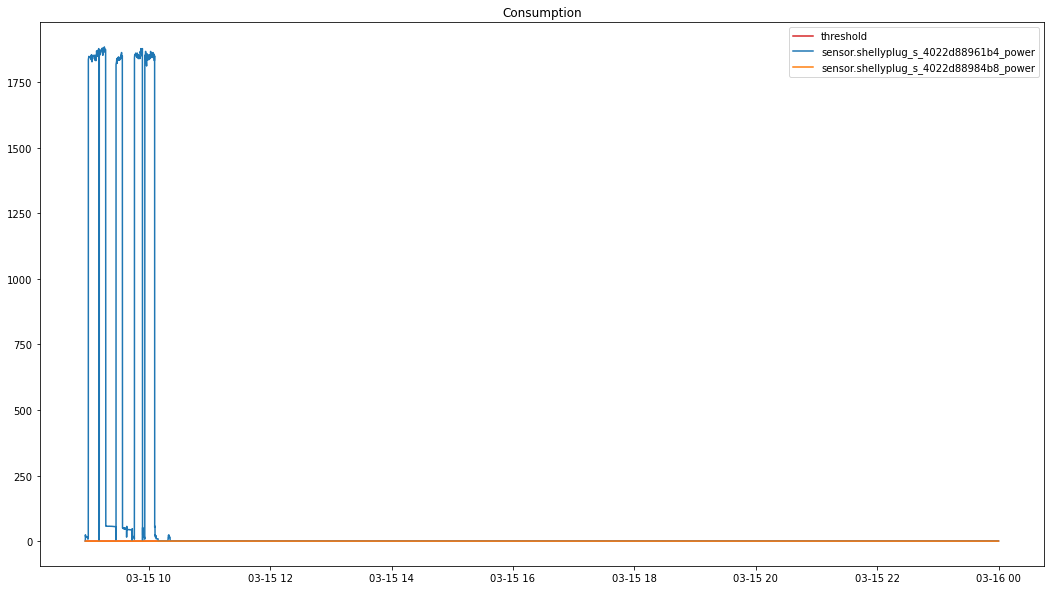

In [88]:
helper.plot_consumption(day, shiftable_devices, figsize=(18,10), threshold=.15)

In [89]:
def visualize_threshold(self, df, threshold, appliances, figsize=(18,5)):
    # data prep
    for appliance in appliances:
        df[str(appliance) + '_usage'] = self.get_device_usage(df, appliance, threshold)
    df = df.join(self.get_time_feature(df))
    df['activity'] = self.get_activity(df, appliances, threshold)

    # plotting 
    import matplotlib.pyplot as plt

    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    columns = ['activity'] + usage_cols

    fig, axes = plt.subplots(1,3, figsize=figsize)

    # hour
    hour = df.groupby('hour').mean()[columns]
    hour.plot(ax=axes[0])
    axes[0].set_ylim(-.1, 1.1);
    axes[0].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per hour')

    # week 
    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    week = df.groupby('day_name').mean()[columns]
    week = week.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    week.plot(ax=axes[1])
    axes[1].set_ylim(-.1, 1.1);
    #axes[1].set_xticklabels(['']+list(week.index), rotation=90)
    axes[1].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per day of the week')

    # month
    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    month = df.groupby('month').mean()[columns]
    month.plot(ax=axes[2])
    axes[2].set_ylim(-.1, 1.1);
    axes[2].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per month')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'visualize_threshold', visualize_threshold)
del visualize_threshold

In [90]:
def validate_thresholds(self, df, thresholds, appliances, figsize=(18,5)):
    import time
    from tqdm import tqdm
    for threshold in tqdm(thresholds):
        self.visualize_threshold(df, threshold, appliances, figsize)
    time.sleep(0.2)
    print('\n')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'validate_thresholds', validate_thresholds)
del validate_thresholds

In [91]:
household_s = household_s.set_index('last_updated_ts')
df = helper.aggregate(household_s, '7T')
thresholds = [0] + list(np.geomspace(.1, .5, 5))

prep.validate_thresholds(df, thresholds, shiftable_devices)

NameError: name 'household_s' is not defined

In [ ]:
thresholds

In [ ]:
threshold = .15

prep.visualize_threshold(df, threshold, shiftable_devices)

### Create dummy test data

In [92]:
def last_reported(self, df):
    return str(df.index.max())[:10]

# add to the Preparation_agent class
setattr(Preparation_Agent, 'last_reported', last_reported)
del last_reported

In [93]:
def days_between(self, d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

# add to the Preparation_agent class
setattr(Preparation_Agent, 'days_between', days_between)
del days_between

In [107]:
def add_dummy_data_tomorrow(self, df):

    today = str(datetime.now())[:10]
    last_updated_ts = self.last_reported(df)
    tomorrow = (pd.to_datetime(today) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
    diff_days = self.days_between(last_updated_ts, today)
    # determine how many hours we need to fill up (missing hours till new day + 23 for tomorrow, day of prediction)
    hours_to_fill = 24 - int(str(df.index.max())[11:13]) + 23 + (24 * diff_days)

    # add rows and fill up with dummy 0
    for i in range(0,hours_to_fill):
        idx = df.tail(1).index[0] + pd.Timedelta(hours=1)
        df.loc[idx] = 0
    return df
# add to the Preparation_agent class
setattr(Preparation_Agent, 'add_dummy_data_tomorrow', add_dummy_data_tomorrow)
del add_dummy_data_tomorrow

In [96]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)

In [ ]:
df  = prep.unpacking_attributes(helper.export_sql(dbfile))
df = prep.access_shiftable_devices(df)
df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
df = df.set_index('last_updated_ts')
# Aggregate to hour level
df = helper.aggregate_load(df, '60T')

In [ ]:
df

In [ ]:
df = prep.add_dummy_data_tomorrow(df)
df

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df['sensor.shellyplug_s_4022d88984b8_power'])

### Friendly Names Pipeline

In [98]:
#pipeline activity
def pipeline_friendly_names(self, df):
    from helper_functions import Helper
    import pandas as pd
    helper = Helper()
    df = df.copy()
    import pandas as pd
    output = pd.DataFrame()

    df  = self.unpacking_attributes(self.input)
    output = self.create_friendly_names(df)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_friendly_names', pipeline_friendly_names)
del pipeline_friendly_names

In [99]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)
prep.pipeline_friendly_names(prep.input)

,entity_id,friendly_name
2,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power
9993,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power


### Activity Pipeline


In [135]:
activity_devices = ["light.olaf_der_gesundigte", "light.blub", "light.extended_color_light_1", "switch.shellyplug_s_80646f824e22", 
                    "light.bogenleuchte", "light.hue_color_candle_1", "light.hue_color_candle_2"]


In [136]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}
#update with active appliances attributes_ids
activity_params = {
    'active_appliances': activity_devices,
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [116]:
#pipeline activity
def pipeline_activity(self, df, params):
    from helper_functions import Helper
    import pandas as pd
    helper = Helper()
    df = df.copy()
    import pandas as pd
    output = pd.DataFrame()

    df  = self.unpacking_attributes(self.input)
    df = self.access_activity_devices(df, self.activity_devices)
    # Data cleaning
    # df = self.truncate(df, **params['truncate'],)
    # df = self.scale(df, **params['scale'])
    # ignore scaling for now, we would just scale those variables, which does not make sense 
    # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')

    df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
    df = df.set_index('last_updated_ts')
    # Aggregate to hour level
    df = helper.aggregate_load(df, **params['aggregate'])
    
    # Add dummy data
    df = self.add_dummy_data_tomorrow(df)
    print("1: ", df)

    # Activity feature
    output['activity'] = self.get_activity(df, **params['activity'])
    print("2: ", output)

    ## Time feature
    output = output.join(self.get_time_feature(df, **params['time']))
    print("3: ", output)

    # Activity lags
    output = output.join(self.get_time_lags(output, **params['activity_lag']))
    print("4: ", output)

    # Dummy coding
    output = pd.get_dummies(output, drop_first=True)
    print("5: ", output)

    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_activity', pipeline_activity)
del pipeline_activity

In [73]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)
df  = prep.unpacking_attributes(prep.input)
df

,state_id,entity_id,state,old_state_id,attributes_id,context_id,context_user_id,context_parent_id,origin_idx,last_updated_ts,...,backups_in_home_assistant,size_in_google_drive,size_in_home_assistant,backups,free_space_in_google_drive,motion_valid,light_level,light_level_valid,temperature_valid,number
0,608714,sensor.shellyplug_s_4022d88961b4_power,0.4,608713.0,60,01GSJVQ5006WP5F0BE871EK7C6,None,None,0,2023-02-18 18:13:57.376302848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,608715,sensor.shellyplug_s_4022d88961b4_power,0.3,608714.0,60,01GSJVQKMRB7EDTQMMR36EJFQR,None,None,0,2023-02-18 18:14:12.376802816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,608716,sensor.shellyplug_s_4022d88961b4_power,0.5,608715.0,60,01GSJVR29G7H5Y8RZHGRVXC2QM,None,None,0,2023-02-18 18:14:27.376713984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,608717,sensor.shellyplug_s_4022d88961b4_power,0.4,608716.0,60,01GSJVRGY8YK8V14151YZM7G5M,None,None,0,2023-02-18 18:14:42.376955904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,608718,sensor.shellyplug_s_4022d88961b4_power,0.0,608717.0,60,01GSJVRZK1NT924DCGVHEAMB10,None,None,0,2023-02-18 18:14:57.377764864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382823,991537,light.olaf_der_gesundigte,unavailable,991522.0,26782,01GVWWERYTT8RJ1X6EQ9FK47X9,None,None,0,2023-03-19 12:10:39.450475008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382824,991538,sensor.shellyplug_s_80646f83efe1_power,0.0,991535.0,6616,01GVWWF1388HDD7VXTAJ6MKW3W,None,None,0,2023-03-19 12:10:47.784705024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382825,991539,sensor.shellyplug_s_4022d88961b4_power,0.4,991534.0,60,01GVWWF305N6KR67SCFN8JKAFQ,None,None,0,2023-03-19 12:10:49.733405952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382826,991540,light.extended_color_light_1,off,991533.0,26882,01GVWWFC9KX1P2PA84C7ECVAXF,None,None,0,2023-03-19 12:10:59.251194112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df = prep.access_activity_devices(df, activity_devices)
df

Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


entity_id,last_updated_ts,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
0,2023-02-18 17:51:12.175996160,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-18 17:51:27.174832128,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-18 17:51:42.194142208,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-18 17:52:12.194013184,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-18 17:52:57.195159808,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
68776,2023-03-18 23:17:23.724399104,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68777,2023-03-18 23:17:23.730386944,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68778,2023-03-18 23:17:24.732954112,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68779,2023-03-18 23:17:24.737384192,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [105]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)
df  = prep.unpacking_attributes(prep.input)
df = prep.access_activity_devices(df, activity_devices)
# Data cleaning
# df = self.truncate(df, **params['truncate'],)
# df = self.scale(df, **params['scale'])
# ignore scaling for now, we would just scale those variables, which does not make sense 
# Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')

df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
df = df.set_index('last_updated_ts')
# Aggregate to hour level
df = helper.aggregate_load(df, '60T')
df

Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
last_updated_ts,,,,,,,,,
2023-02-18 17:00:00,0.361111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 18:00:00,0.354545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 19:00:00,0.372414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 20:00:00,0.360305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 21:00:00,0.354135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-03-19 08:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-19 09:00:00,1250.769756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-19 10:00:00,610.157577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
df['light.blub'].unique()

array([0.        , 0.33333333, 0.03030303, 0.15384615, 0.02941176,
       0.48951049, 0.12      , 0.48170732, 0.5       , 0.25      ,
       0.02083333, 0.4137931 , 0.45454545, 0.2       , 0.53333333,
       0.07692308, 0.38461538, 0.24242424, 0.35714286, 0.22222222,
       0.27272727, 0.05555556, 0.05263158, 0.42857143, 0.0625    ,
       0.3       , 0.03571429, 0.6       , 0.475     , 0.42105263,
       0.28571429, 0.29032258, 0.03448276, 0.14285714, 0.48275862,
       0.3125    , 1.        , 0.29411765, 0.47863248, 0.66666667,
       0.4       , 0.31578947, 0.28      , 0.13157895])

In [108]:
df = prep.add_dummy_data_tomorrow(df)
df

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,light.blub,light.bogenleuchte,light.extended_color_light_1,light.hue_color_candle_1,light.hue_color_candle_2,light.olaf_der_gesundigte,switch.shellyplug_s_80646f824e22
last_updated_ts,,,,,,,,,
2023-02-18 17:00:00,0.361111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 18:00:00,0.354545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 19:00:00,0.372414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 20:00:00,0.360305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18 21:00:00,0.354135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-03-21 19:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-21 20:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-21 21:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)

In [118]:
prep.pipeline_activity(prep.input, activity_pipe_params)

Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


1:  entity_id            sensor.shellyplug_s_4022d88961b4_power  \
last_updated_ts                                               
2023-02-18 17:00:00                                0.361111   
2023-02-18 18:00:00                                0.354545   
2023-02-18 19:00:00                                0.372414   
2023-02-18 20:00:00                                0.360305   
2023-02-18 21:00:00                                0.354135   
...                                                     ...   
2023-03-21 19:00:00                                0.000000   
2023-03-21 20:00:00                                0.000000   
2023-03-21 21:00:00                                0.000000   
2023-03-21 22:00:00                                0.000000   
2023-03-21 23:00:00                                0.000000   

entity_id            sensor.shellyplug_s_4022d88984b8_power  light.blub  \
last_updated_ts                                                           
2023-02-18 17:00:00       

,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated_ts,,,,,,,,,,,
2023-02-18 17:00:00,0,17,NaN,NaN,NaN,0,1,0,0,0,0
2023-02-18 18:00:00,0,18,NaN,NaN,NaN,0,1,0,0,0,0
2023-02-18 19:00:00,0,19,NaN,NaN,NaN,0,1,0,0,0,0
2023-02-18 20:00:00,0,20,NaN,NaN,NaN,0,1,0,0,0,0
2023-02-18 21:00:00,0,21,NaN,NaN,NaN,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21 19:00:00,0,19,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 20:00:00,0,20,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 21:00:00,0,21,0.0,0.0,1.0,0,0,0,0,1,0


### Load Pipeline

The load agent requires cleaned energy consumption data for the shiftable devices. Therefore, we calculate the device usage for these appliances based on the truncated and scaled data and return the energy consumption of the shiftable devices only if we detected a device usage. The data for the load agent will be aggregated to the hour level.


In [113]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

In [114]:
#pipeline load
def pipeline_load(self, df, params):
    from helper_functions import Helper
    import pandas as pd
    helper = Helper()

    df  = self.unpacking_attributes(self.input)
    df = self.access_shiftable_devices(df)

    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    # df = self.truncate(df, **params['truncate'],)
    # scaled = self.scale(df, **params['scale'])
    # ignore scaling for now, we would just scale those variables, which does not make sense 
    # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')
    scaled = df.copy()

    df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
    df = df.set_index('last_updated_ts')

    scaled['last_updated_ts'] = pd.to_datetime(scaled['last_updated_ts'])
    scaled = scaled.set_index('last_updated_ts')

    # aggregate
    df = helper.aggregate_load(df, **params['aggregate'])
    scaled = helper.aggregate_load(scaled, **params['aggregate'])
    
    # add dummy data
    df = self.add_dummy_data_tomorrow(df)

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        df[str(device) + '_usage'] = self.get_device_usage(df, device, **params['device'])
        output[device] = df.apply(lambda timestamp: timestamp[device] * timestamp[str(device) + '_usage'], axis = 1)

    return output, scaled, df

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_load', pipeline_load)
del pipeline_load

In [115]:
output, scaled, df = prep.pipeline_load(prep.input, load_pipe_params)
output

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-02-18 18:00:00,0.368354,0.0
2023-02-18 19:00:00,0.372414,0.0
2023-02-18 20:00:00,0.360305,0.0
2023-02-18 21:00:00,0.354135,0.0
2023-02-18 22:00:00,0.361268,0.0
...,...,...
2023-03-21 19:00:00,0.000000,0.0
2023-03-21 20:00:00,0.000000,0.0
2023-03-21 21:00:00,0.000000,0.0


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df['sensor.shellyplug_s_4022d88984b8_power'])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(output['sensor.shellyplug_s_4022d88984b8_power'])


<font color = "red"> Here, what should I do with NAs? </font>

### Usage Pipeline

We will use the same functionality from the activity pipeline to create the activity feature for the usage agent. Furthermore, we create the device usage features for the appliances for which we will provide recommendations. As appliances for which we will provide recommendations, we used appliances that require user interaction and are time-shiftable, i.e. not bound to any specific time during the day (e.g. Television, Computer, etc.). These appliances will be called “shiftable devices”. Additionally, we create the periods since last usage feature for the shiftable devices, create time lags for activity and the shiftable devices, add further time features and aggregate the data to the day level. 


In [ ]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_hour_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': shiftable_devices,
    'threshold': .1
}

shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

device_params = {
    'threshold': 0.15
}

aggregate_day_params = {
    'resample_param': '1D'
}

time_params = {
    'features': ['day_name', 'weekend']
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate_hour': aggregate_hour_params,
    'activity': activity_params,
    'aggregate_day': aggregate_day_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params,
    'time': time_params
}

In [ ]:
#pipeline usage
def pipeline_usage(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    helper = Helper()

    df  = self.unpacking_attributes(self.input)
    df = self.access_shiftable_devices(df)

    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    # df = self.truncate(df, **params['truncate'],)
    # scaled = self.scale(df, **params['scale'])
    # ignore scaling for now, we would just scale those variables, which does not make sense 
    # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')
    scaled = df.copy()

    # df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
    # df = df.set_index('last_updated_ts')
    scaled['last_updated_ts'] = pd.to_datetime(scaled['last_updated_ts'])
    scaled = scaled.set_index('last_updated_ts')

    # Aggregate to hour level
    scaled = helper.aggregate_load(scaled, **params['aggregate_hour'])
    
    # Add dummy data
    scaled = self.add_dummy_data_tomorrow(scaled)

    # Activity feature
    output['activity'] = self.get_activity(scaled, **params['activity'])

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        output[str(device) + '_usage'] = self.get_device_usage(scaled, device, **params['device'])

    # aggregate and convert from mean to binary
    output = helper.aggregate(output, **params['aggregate_day'])
    output = output.apply(lambda x: (x > 0).astype('int'))

    # Last usage
    output = output.join(self.get_last_usages(output, output.columns))

    # Time features
    output = output.join(self.get_time_feature(output, **params['time']))

    # lags
    output = output.join(self.get_time_lags(output, ['activity'] + [str(device)+'_usage' for device in params['shiftable_devices']], [1,2,3]))
    output['active_last_2_days'] = ((output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)).astype('int')

    # dummy coding
    output = pd.get_dummies(output, drop_first=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_usage', pipeline_usage)
del pipeline_usage

In [ ]:
output = prep.pipeline_usage(prep.input, usage_pipe_params)

In [ ]:
output

### Final: Complete Preparation Agent Class

In [151]:
###################################################################################################
# preparation agent ###############################################################################
###################################################################################################
class Preparation_Agent:
    import pandas as pd
    
    def __init__(self, dbfile, shiftable_devices, activity_devices = [], training_days = 60):
        from helper_functions import Helper
        helper = Helper()
        self.input = helper.export_sql(file = dbfile, number_days = training_days)
        self.shiftable_devices = shiftable_devices
        self.activity_devices = activity_devices + shiftable_devices
        self.training_days = training_days

    def unpacking_attributes(self, df):
        import pandas as pd
        output = df.copy()
        output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('true','True'))
        output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('false','False'))
        output['shared_attrs']=output['shared_attrs'].apply(lambda x: x.replace('null','None'))

        output['shared_attrs']=output['shared_attrs'].apply(lambda dat: dict(eval(dat)))
        df2 = pd.json_normalize(output['shared_attrs'])
        result = pd.DataFrame( pd.concat([output,df2], axis = 1).drop('shared_attrs', axis = 1))
        result = result.dropna(axis = 1, thresh=int(0.95*(len(result.columns))))
        return result

    #updated
    def create_friendly_names(self, df):
        from datetime import datetime
        trial = df.copy()
        trial.attributes_id = trial.attributes_id.dropna()
        trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
        w_data = trial[trial.unit_of_measurement.isin(['W'])]
        w_data = w_data[w_data.entity_id.isin(self.shiftable_devices)]
        last_30_days = (datetime.now() - pd.Timedelta(days=30)).strftime("%Y-%m-%d")
        w_data = w_data[(w_data['last_updated_ts'] > last_30_days)]
        friendly_names = w_data[['entity_id','friendly_name']]
        friendly_name_map = friendly_names.drop_duplicates()
        return(friendly_name_map)
    
    def access_activity_devices(self, df):
        # data for watt devices
        trial = df.copy()
        trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
        w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.entity_id.isin(self.activity_devices)]
        w_data_long = w_data[['entity_id','last_updated_ts','state']]
        w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
        w_data_wide = w_data_wide.fillna(0).reset_index()
        # data for state devices
        trial = df.copy()
        s_data = trial[trial.state == 'on']
        s_data.state.loc[s_data.state == 'on'] = 1
        s_data = s_data[trial.entity_id.isin(self.activity_devices)]
        s_data_long = s_data[['entity_id','last_updated_ts','state']]
        s_data_wide = pd.pivot(s_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
        s_data_wide = s_data_wide.fillna(0).reset_index()
        
        result = pd.merge(w_data_wide, s_data_wide, how='outer')
        return(result)

    def access_shiftable_devices(self, df, attrs= 'all'):
        import pandas as pd
        trial = df.copy()
        trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
        if attrs == 'all':
            w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.entity_id.isin(self.shiftable_devices)]
            w_data_long = w_data[['entity_id','last_updated_ts','state']]
            w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
        if attrs != 'all':
            w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.entity_id.isin(self.shiftable_devices)]
            w_data_long = w_data[['entity_id','last_updated_ts','state']]
            w_data_wide = pd.pivot(w_data_long,  index = ['last_updated_ts'], columns = 'entity_id', values = 'state')
        result = w_data_wide.fillna(0).reset_index()
        return(result)
    
    #basic preprocessing
    # -------------------------------------------------------------------------------------------
    def outlier_truncation(self, series, factor=1.5, verbose=0):
        from tqdm import tqdm
        
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3-q1
        
        lower_bound = q1 - factor*iqr
        upper_bound = q3 + factor*iqr
        
        output = []
        counter = 0
        for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
            if item > upper_bound:
                output.append(int(upper_bound))
                counter += 1
            elif item < lower_bound:
                output.append(int(lower_bound))
                counter += 1
            else:
                output.append(item)
        print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
        return output
    
    def scale(self, df, features='all', kind='MinMax', verbose=0):
        output = df.copy()
        features = output.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

        if kind == 'MinMax':
            from sklearn.preprocessing import MinMaxScaler
            
            scaler = MinMaxScaler()
            output[features] = scaler.fit_transform(output[features])
            print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
        else:
            raise InputError('Chosen scaling method is not available.')
        return output 

    def get_timespan(self, df, start, timedelta_params):
        df.last_updated_ts = pd.to_datetime(df.last_updated_ts)
        df = df.set_index('last_updated_ts')
        start = pd.to_datetime(start) if type(start) != type(pd.to_datetime('1970-01-01')) else start 
        end = start + pd.Timedelta(**timedelta_params)
        return df[start:end].reset_index()
    
    def truncate(self, df, features='all', factor=1.5, verbose=0):
        import time
        output = df.copy()
        features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

        for feature in features:
            time.sleep(0.2) if verbose != 0 else None
            row_nn = df[feature] != 0                                                                  # truncate only the values for which the device uses energy
            output.loc[row_nn, feature] = self.outlier_truncation(df.loc[row_nn, feature], factor=factor, verbose=verbose) # Truncatation factor = 1.5 * IQR
            print('\n') if verbose != 0 else None
        return output
    
    def last_reported(self, df):
        return str(df.index.max())[:10]
    
    def days_between(self, d1, d2):
        d1 = datetime.strptime(d1, "%Y-%m-%d")
        d2 = datetime.strptime(d2, "%Y-%m-%d")
        return abs((d2 - d1).days)

    
    def add_dummy_data_tomorrow(self, df):

        today = str(datetime.now())[:10]
        last_updated_ts = self.last_reported(df)
        tomorrow = (pd.to_datetime(today) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        diff_days = self.days_between(last_updated_ts, today)
        # determine how many hours we need to fill up (missing hours till new day + 23 for tomorrow, day of prediction)
        hours_to_fill = 24 - int(str(df.index.max())[11:13]) + 23 + (24 * diff_days)

        # add rows and fill up with dummy 0
        for i in range(0,hours_to_fill):
            idx = df.tail(1).index[0] + pd.Timedelta(hours=1)
            df.loc[idx] = 0
        return df
    
    def plot_consumption(self, df, features='all', figsize='default', threshold=None, title='Consumption'):
        df = df.copy()
        features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features
        fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
        if threshold != None:
            df['threshold'] = [threshold]*df.shape[0]
            ax.plot(df['threshold'], color = 'tab:red')
        for feature in features:
            ax.plot(df[feature])
        ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
        ax.set_title(title);
    # feature creation
    # -------------------------------------------------------------------------------------------
    def get_device_usage(self, df, device, threshold):
        return (df.loc[:, device] >= threshold).astype('int')

    def get_activity(self, df, active_appliances, threshold):
        import pandas as pd
        active = pd.DataFrame({appliance: df[appliance] >= threshold for appliance in active_appliances})
        return active.apply(any, axis = 1).astype('int')

    def get_last_usage(self, series):
        import pandas as pd
        last_usage = []
        for idx in range(len(series)):
            shift = 1
            if pd.isna(series.shift(periods = 1)[idx]):
                shift = None
            else:
                while series.shift(periods = shift)[idx] == 0:
                    shift += 1
            last_usage.append(shift)
        return last_usage

    def get_last_usages(self, df, features):
        import pandas as pd

        output = pd.DataFrame()
        for feature in features:
            output['periods_since_last_'+str(feature)] = self.get_last_usage(df[feature])
        output.set_index(df.index, inplace=True)
        return output


    def get_time_feature(self, df, features='all'):
        import pandas as pd
        functions = {
            'hour': lambda df: df.index.hour, 
            'day_of_week': lambda df: df.index.dayofweek,
            'day_name': lambda df: df.index.day_name().astype('category'),
            'month': lambda df: df.index.month, 
            'month_name': lambda df: df.index.month_name().astype('category'),
            'weekend': lambda df: [int(x in ['Saturday', 'Sunday']) for x in  list(df.index.day_name())]
        }
        if features == 'all':
            output = pd.DataFrame({function[0]: function[1](df) for function in functions.items()})
        else:
            output = pd.DataFrame({function[0]: function[1](df) for function in functions.items() if function[0] in features})
        output.set_index(df.index, inplace=True)
        return output
    
    def get_time_lags(self, df, features, lags):
        import pandas as pd
        output = pd.DataFrame()
        for feature in features:
            for lag in lags:
                output[f'{feature}_lag_{lag}'] = df[feature].shift(periods=lag)
        return output

    #visualising threshold
    # ------------------------------------------------------------------------------------------- 
    def visualize_threshold(self, df, threshold, appliances, figsize=(18,5)):
        import pandas as pd
        # data prep
        for appliance in appliances:
            df[str(appliance) + '_usage'] = self.get_device_usage(df, appliance, threshold)
        df = df.join(self.get_time_feature(df))
        df['activity'] = self.get_activity(df, appliances, threshold)

        # plotting 
        import matplotlib.pyplot as plt

        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        columns = ['activity'] + usage_cols

        fig, axes = plt.subplots(1,3, figsize=figsize)

        # hour
        hour = df.groupby('hour').mean()[columns]
        hour.plot(ax=axes[0])
        axes[0].set_ylim(-.1, 1.1);
        axes[0].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per hour')

        # week 
        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        week = df.groupby('day_name').mean()[columns]
        week = week.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        week.plot(ax=axes[1])
        axes[1].set_ylim(-.1, 1.1);
        #axes[1].set_xticklabels(['']+list(week.index), rotation=90)
        axes[1].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per day of the week')

        # month
        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        month = df.groupby('month').mean()[columns]
        month.plot(ax=axes[2])
        axes[2].set_ylim(-.1, 1.1);
        axes[2].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per month')
    def validate_thresholds(self, df, thresholds, appliances, figsize=(18,5)):

        for threshold in tqdm(thresholds):
            self.visualize_threshold(df, threshold, appliances, figsize)
        time.sleep(0.2)
        print('\n')
    
    #pipelines
    # -------------------------------------------------------------------------------------------
    #pipeline friendly_names
    def pipeline_friendly_names(self, df):
        from helper_functions import Helper
        import pandas as pd
        helper = Helper()
        df = df.copy()
        import pandas as pd
        output = pd.DataFrame()

        df  = self.unpacking_attributes(self.input)
        output = self.create_friendly_names(df)
        return output
    
    #pipeline load
    def pipeline_load(self, df, params):
        from helper_functions import Helper
        import pandas as pd
        helper = Helper()
        
        df  = self.unpacking_attributes(self.input)
        df = self.access_shiftable_devices(df)
        
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        # df = self.truncate(df, **params['truncate'],)
        # scaled = self.scale(df, **params['scale'])
        # ignore scaling for now, we would just scale those variables, which does not make sense 
        # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')
        scaled = df.copy()

        df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
        df = df.set_index('last_updated_ts')

        scaled['last_updated_ts'] = pd.to_datetime(scaled['last_updated_ts'])
        scaled = scaled.set_index('last_updated_ts')

        # aggregate
        df = helper.aggregate_load(df, **params['aggregate'])
        scaled = helper.aggregate_load(scaled, **params['aggregate'])
        
        # Add dummy data
        df = self.add_dummy_data_tomorrow(df)
        scaled = self.add_dummy_data_tomorrow(scaled)

        # Get device usage and transform to energy consumption
        for device in params['shiftable_devices']:
            df[str(device) + '_usage'] = self.get_device_usage(df, device, **params['device'])
            output[device] = df.apply(lambda timestamp: timestamp[device] * timestamp[str(device) + '_usage'], axis = 1)

        return output, scaled, df
    #pipeline usage
    def pipeline_usage(self, df, params):
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()

        df  = self.unpacking_attributes(self.input)
        df = self.access_shiftable_devices(df)
        
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        # df = self.truncate(df, **params['truncate'],)
        # scaled = self.scale(df, **params['scale'])
        # ignore scaling for now, we would just scale those variables, which does not make sense 
        # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')
        scaled = df.copy()
        
        # df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
        # df = df.set_index('last_updated_ts')
        scaled['last_updated_ts'] = pd.to_datetime(scaled['last_updated_ts'])
        scaled = scaled.set_index('last_updated_ts')
        
        # Aggregate to hour level
        scaled = helper.aggregate_load(scaled, **params['aggregate_hour'])
        
        # Add dummy data
        scaled = self.add_dummy_data_tomorrow(scaled)


        # Activity feature
        output['activity'] = self.get_activity(scaled, **params['activity'])

        # Get device usage and transform to energy consumption
        for device in params['shiftable_devices']:
            output[str(device) + '_usage'] = self.get_device_usage(scaled, device, **params['device'])

        # aggregate and convert from mean to binary
        output = helper.aggregate(output, **params['aggregate_day'])
        output = output.apply(lambda x: (x > 0).astype('int'))

        # Last usage
        output = output.join(self.get_last_usages(output, output.columns))
        
        # Time features
        output = output.join(self.get_time_feature(output, **params['time']))

        # lags
        output = output.join(self.get_time_lags(output, ['activity'] + [str(device)+'_usage' for device in params['shiftable_devices']], [1,2,3]))
        output['active_last_2_days'] = ((output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)).astype('int')

        # dummy coding
        output = pd.get_dummies(output, drop_first=True)
        return output

    #pipeline activity
    def pipeline_activity(self, df, params):
        from helper_functions import Helper
        import pandas as pd
        helper = Helper()
        df = df.copy()
        import pandas as pd
        output = pd.DataFrame()

        df = self.unpacking_attributes(self.input)
        df = self.access_activity_devices(df)
        # Data cleaning
        # df = self.truncate(df, **params['truncate'],)
        # df = self.scale(df, **params['scale'])
        # ignore scaling for now, we would just scale those variables, which does not make sense 
        # Index(['state_id', 'old_state_id', 'attributes_id', 'origin_idx', 'hash'], dtype='object')

        df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
        df = df.set_index('last_updated_ts')
        # Aggregate to hour level
        df = helper.aggregate_load(df, **params['aggregate'])

        # Add dummy data
        df = self.add_dummy_data_tomorrow(df)

        # Activity feature
        output['activity'] = self.get_activity(df, **params['activity'])

        ## Time feature
        output = output.join(self.get_time_feature(df, **params['time']))

        # Activity lags
        output = output.join(self.get_time_lags(output, **params['activity_lag']))

        # Dummy coding
        output = pd.get_dummies(output, drop_first=True)

        return output

In [138]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)
df = prep.pipeline_activity(prep.input, activity_pipe_params)
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


1:  entity_id            sensor.shellyplug_s_4022d88961b4_power  \
last_updated_ts                                               
2023-01-19 19:00:00                                     0.0   
2023-01-19 20:00:00                                     0.0   
2023-01-19 21:00:00                                     0.0   
2023-01-19 22:00:00                                     0.0   
2023-01-19 23:00:00                                     0.0   
...                                                     ...   
2023-03-21 19:00:00                                     0.0   
2023-03-21 20:00:00                                     0.0   
2023-03-21 21:00:00                                     0.0   
2023-03-21 22:00:00                                     0.0   
2023-03-21 23:00:00                                     0.0   

entity_id            sensor.shellyplug_s_4022d88984b8_power  light.blub  \
last_updated_ts                                                           
2023-01-19 19:00:00       

,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated_ts,,,,,,,,,,,
2023-01-19 19:00:00,1,19,NaN,NaN,NaN,0,0,0,1,0,0
2023-01-19 20:00:00,0,20,NaN,NaN,NaN,0,0,0,1,0,0
2023-01-19 21:00:00,0,21,NaN,NaN,NaN,0,0,0,1,0,0
2023-01-19 22:00:00,0,22,NaN,NaN,NaN,0,0,0,1,0,0
2023-01-19 23:00:00,0,23,NaN,NaN,NaN,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21 19:00:00,0,19,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 20:00:00,0,20,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 21:00:00,0,21,0.0,0.0,1.0,0,0,0,0,1,0


In [152]:
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]
activity_devices = ["light.olaf_der_gesundigte", "light.blub", "light.extended_color_light_1", "switch.shellyplug_s_80646f824e22", 
                    "light.bogenleuchte", "light.hue_color_candle_1", "light.hue_color_candle_2"]
date = '2023-03-19'
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 0
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 0
}

aggregate_params = {
    'resample_param': '60T'
}
aggregate_params24_H = {
    'resample_param': '24H'
}

activity_params_usage = {
    'active_appliances': shiftable_devices,
    'threshold': .10
}

activity_params = {
    'active_appliances': activity_devices,
    'threshold': .10
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

device = {
    'threshold' : .10}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'activity': activity_params_usage,
    'aggregate_hour': aggregate_params,
    'aggregate_day': aggregate_params24_H,
    'time': time_params,
    'activity_lag': activity_lag_params,
    'shiftable_devices' : shiftable_devices,
    'device': device
}

device_params = {
    'threshold': 0.10
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

model_type = 'random forest'
number_days = 60

In [153]:
prep = Preparation_Agent(dbfile, shiftable_devices, activity_devices)

In [144]:
activity_df = prep.pipeline_activity(prep.input, activity_pipe_params)
activity_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated_ts,,,,,,,,,,,
2023-01-20 07:00:00,1,7,NaN,NaN,NaN,0,0,0,0,0,0
2023-01-20 08:00:00,0,8,NaN,NaN,NaN,0,0,0,0,0,0
2023-01-20 09:00:00,0,9,NaN,NaN,NaN,0,0,0,0,0,0
2023-01-20 10:00:00,0,10,NaN,NaN,NaN,0,0,0,0,0,0
2023-01-20 11:00:00,0,11,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21 19:00:00,0,19,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 20:00:00,0,20,0.0,0.0,1.0,0,0,0,0,1,0
2023-03-21 21:00:00,0,21,0.0,0.0,1.0,0,0,0,0,1,0


In [145]:
load_df, _, _ = prep.pipeline_load(prep.input, load_pipe_params)
load_df

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated_ts,,
2023-01-20 11:00:00,0.0,0.0
2023-01-20 12:00:00,0.0,0.0
2023-01-20 13:00:00,0.0,0.0
2023-01-20 14:00:00,0.0,0.0
2023-01-20 15:00:00,0.0,0.0
...,...,...
2023-03-21 19:00:00,0.0,0.0
2023-03-21 20:00:00,0.0,0.0
2023-03-21 21:00:00,0.0,0.0


In [154]:
usage_df = prep.pipeline_usage(prep.input, usage_pipe_params)
usage_df

,activity,sensor.shellyplug_s_4022d88961b4_power_usage,sensor.shellyplug_s_4022d88984b8_power_usage,periods_since_last_activity,periods_since_last_sensor.shellyplug_s_4022d88961b4_power_usage,periods_since_last_sensor.shellyplug_s_4022d88984b8_power_usage,hour,activity_lag_1,activity_lag_2,activity_lag_3,...,sensor.shellyplug_s_4022d88984b8_power_usage_lag_1,sensor.shellyplug_s_4022d88984b8_power_usage_lag_2,sensor.shellyplug_s_4022d88984b8_power_usage_lag_3,active_last_2_days,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated_ts,,,,,,,,,,,,,,,,,,,,,
2023-01-20,1,0,1,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2023-01-21,1,1,1,1.0,2.0,1.0,0,1.0,NaN,NaN,...,1.0,NaN,NaN,1,0,1,0,0,0,0
2023-01-22,1,1,1,1.0,1.0,1.0,0,1.0,1.0,NaN,...,1.0,1.0,NaN,1,0,0,1,0,0,0
2023-01-23,0,0,0,1.0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,1.0,1.0,1,1,0,0,0,0,0
2023-01-24,1,1,0,2.0,2.0,2.0,0,0.0,1.0,1.0,...,0.0,1.0,1.0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-17,1,1,0,1.0,1.0,3.0,0,1.0,1.0,1.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
2023-03-18,1,1,1,1.0,1.0,4.0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,1,0,1,0,0,0,0
2023-03-19,1,1,0,1.0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,0.0,0.0,1,0,0,1,0,0,0


In [146]:
friendly_names = prep.pipeline_friendly_names(prep.input)
friendly_names

,entity_id,friendly_name
9007,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power
9013,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power
